### Гистограмма направленных градиентов (HOG)

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
img = cv2.imread("squirrel.jpg")

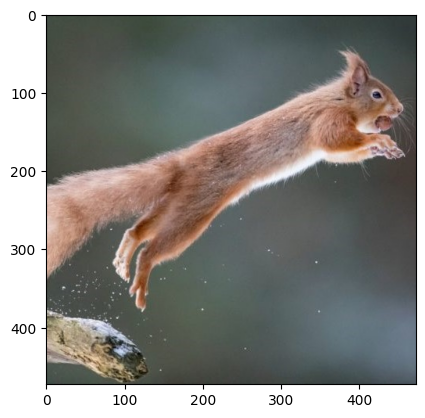

In [ ]:
rgb_img = img[:, :, ::-1]
plt.imshow(rgb_img);

In [ ]:
def hog(img, mode = "stats"):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)

    bin_n = 16
    bin = np.int32(bin_n * ang / (2 * np.pi))

    bin_cells = []
    mag_cells = []

    cellx = celly = 8

    for i in range(0, int(img.shape[0] / celly)):
        for j in range(0, int(img.shape[1] / cellx)):
            temp = bin[i * celly : i * celly + celly, j * cellx : j * cellx + cellx]
            values, counts = np.unique(temp.ravel(), return_counts=True)

            dict_v_c = dict(zip(values, counts))
            dict_c_v = dict(zip(counts, values))

            norm_coef = counts.max()

            if mode == "stats":
                temp_answer = []

                for k in range(bin_n):
                    if k in dict_v_c:
                        temp_answer.append(dict_v_c[k] / norm_coef)
                    else:
                        temp_answer.append(0.0)

                bin_cells.append(temp_answer)
            else:
                bin_cells.append(dict_c_v[norm_coef])

    return np.array(bin_cells).ravel()

In [ ]:
hog(img, mode = "stats")

array([0.54545455, 0.11363636, 0.06818182, ..., 0.11650485, 0.04854369,
       0.00970874])

Для достижения инвариантности HOG-дескриптора относительно поворота изображения будем поворачивать его на фиксированный угол в цикле, рассчитывая значения HOG на каждом шаге. Итоговый дескриптор получим путем усреднения этих значений, что обеспечит обобщенную характеристику в независимости от ориентации объекта.

In [7]:
def hog_with_rotation(img, mode="stats", rotation_step=15):
    def calculate_hog(img, mode):
        gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
        gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
        mag, ang = cv2.cartToPolar(gx, gy)

        bin_n = 16
        bin = np.int32(bin_n * ang / (2 * np.pi))

        bin_cells = []
        cellx = celly = 8

        for i in range(0, int(img.shape[0] / celly)):
            for j in range(0, int(img.shape[1] / cellx)):
                temp = bin[i * celly: i * celly + celly, j * cellx: j * cellx + cellx]
                values, counts = np.unique(temp.ravel(), return_counts=True)

                dict_v_c = dict(zip(values, counts))
                norm_coef = counts.max()

                if mode == "stats":
                    temp_answer = []
                    for k in range(bin_n):
                        temp_answer.append(dict_v_c.get(k, 0) / norm_coef)
                    bin_cells.append(temp_answer)
                else:
                    bin_cells.append(dict_v_c.get(counts.max(), 0))

        return np.array(bin_cells).ravel()

    height, width = img.shape[:2]
    center = (width // 2, height // 2)
    final_hog = None
    count = 0

    for angle in range(0, 360, rotation_step):
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_img = cv2.warpAffine(img, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

        current_hog = calculate_hog(rotated_img, mode)

        if final_hog is None:
            final_hog = current_hog
        else:
            final_hog += current_hog
        count += 1

    final_hog /= count
    return final_hog

In [8]:
def rotate_image(img, angle):
    center = (img.shape[1] // 2, img.shape[0] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))

def L1(h1, h2):
    return np.sum(np.abs(h1 - h2))

def L2(h1, h2):
    return np.sqrt(np.sum((h1 - h2) ** 2))

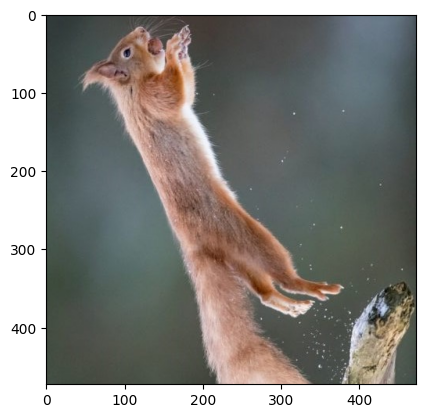

In [9]:
rotated_img = rotate_image(img, 90)
plt.imshow(rotated_img[:, :, ::-1]);

In [10]:
def compare_results_hog(img1, img2):
    hog1 = hog(img1)
    hog2 = hog(img2)

    print('HOG')
    print(f" L1: {L1(hog1, hog2)}")
    print(f" L2: {L2(hog1, hog2)}")
    print()
    hog3 = hog_with_rotation(img1)
    hog4 = hog_with_rotation(img2)

    print('HOG, инвариантный к повороту')
    print(f" L1: {L1(hog3, hog4)}")
    print(f" L2: {L2(hog3, hog4)}")

compare_results_hog(img, rotated_img)

HOG
 L1: 16956.77010617611
 L2: 95.69923760953931

HOG, инвариантный к повороту
 L1: 52.7223722072944
 L2: 0.41294714846171177


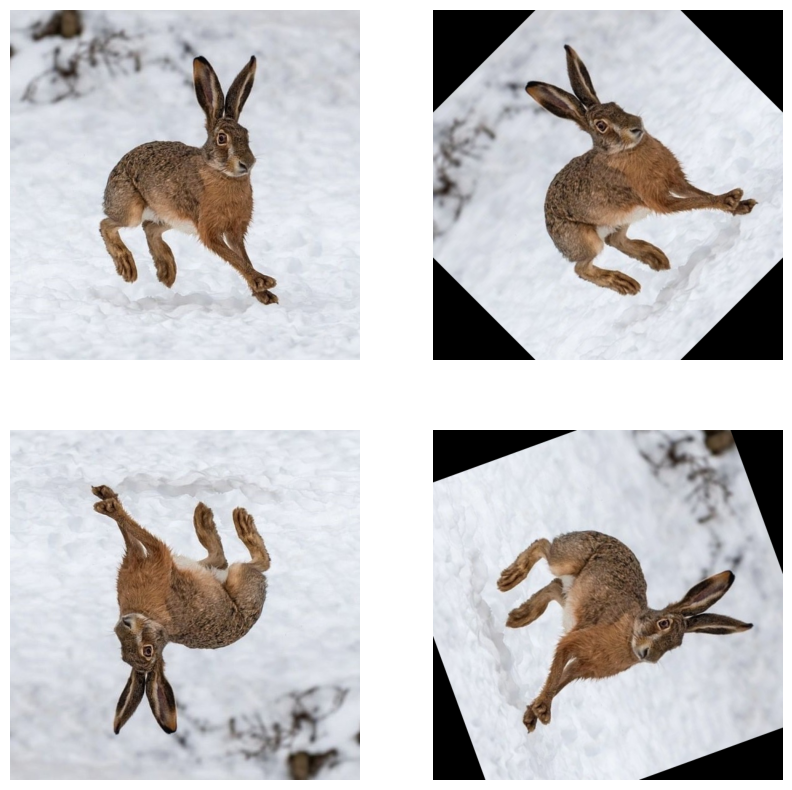

In [11]:
img = cv2.imread("rabbit.jpg")
rotated_img1 = rotate_image(img, 45)
rotated_img2 = rotate_image(img, 180)
rotated_img3 = rotate_image(img, 290)

plt.figure(figsize=(10,10))

plt.subplot(2, 2, 1)
plt.imshow(img[:, :, ::-1])
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(rotated_img1[:, :, ::-1])
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(rotated_img2[:, :, ::-1])
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(rotated_img3[:, :, ::-1])
plt.axis('off');

In [12]:
compare_results_hog(img, rotated_img1)

HOG
 L1: 24376.49151408607
 L2: 118.10630586563155

HOG, инвариантный к повороту
 L1: 3131.6042922383976
 L2: 19.28132911284967


In [13]:
compare_results_hog(img, rotated_img2)

HOG
 L1: 24791.470743979968
 L2: 117.14825004696492

HOG, инвариантный к повороту
 L1: 127.58589778035207
 L2: 0.7361219526027434


In [14]:
compare_results_hog(img, rotated_img3)

HOG
 L1: 24977.784899330105
 L2: 119.54892850606863

HOG, инвариантный к повороту
 L1: 5541.190441210603
 L2: 25.096944141552488


Видно, что расстояния L1 и L2 между двумя результатами меньше у доработанного дескриптора.

In [20]:
%%time
hog(img)

CPU times: user 446 ms, sys: 19.9 ms, total: 466 ms
Wall time: 464 ms


array([0.26666667, 0.06666667, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [21]:
%%time
hog_with_rotation(img)

CPU times: user 9.43 s, sys: 240 ms, total: 9.67 s
Wall time: 9.64 s


array([0.69899383, 0.2410204 , 0.15506381, ..., 0.16509501, 0.28712069,
       0.21861854])

Усредненное значение hog-дескриптора ищется при этом сильно дольше.